# **Vector Space Model (VSM) Evaluation Notebook**

## **Objective**
This notebook will serve as the testing site for comparing different **Vector Space Model (VSM) approaches** using various word embeddings.

## **Approaches Compared**
1. **Word2Vec Pretrained**  
2. **Word2Vec Fine-tuned (Pretrained + Own Data)**  
3. **Word2Vec Trained from Scratch on Own Data**  
4. **GloVe**  
5. **FastText**  

## **Evaluation Methods**
Each method will be evaluated using the following criteria:

### **A. Word Similarity Evaluation**
Measure the similarity between words using cosine similarity.

```python
print(word2vec_model.similarity("car", "vehicle"))
print(glove_model.similarity("car", "vehicle"))
print(custom_word2vec.wv.similarity("car", "vehicle"))
```

### **B. Document Vector Representation**
Compute document vectors by averaging the word embeddings of the words they contain.

```python
import numpy as np
from nltk.tokenize import word_tokenize

def get_document_vector(model, text):
    words = word_tokenize(text.lower())
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

doc_vector = get_document_vector(word2vec_model, "This is a test document.")
```

### **C. Clustering (K-Means)**
Cluster documents using K-Means clustering based on their computed document vectors.
```python
from sklearn.cluster import KMeans

# Example document vectors
doc_vectors = [get_document_vector(word2vec_model, doc) for doc in documents]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(doc_vectors)

print("Cluster assignments:", clusters)
```

### **D. Text Classification**
Use document embeddings as input for a classification model and evaluate its accuracy. (finally)


```python

```



--------------

In [8]:
import os
import numpy as np
import gensim.downloader as api

# Load the pretrained Word2Vec model
model = api.load("word2vec-google-news-300")  # Google's 300-dim Word2Vec

# Define the directory path
accessories_dir = "../02-data/00-testing/03-demo/"

# Initialize a dictionary to store document vectors
document_vectors = {}

# Iterate through all subdirectories
for root, _, _ in os.walk(accessories_dir):
    folder_name = os.path.basename(root)  # Folder name
    txt_filename = f"{folder_name}.txt"  # Expected text file name
    txt_path = os.path.join(root, txt_filename)

    try:
        # Read and preprocess the text file
        with open(txt_path, "r", encoding="utf-8") as f:
            text = f.read().split()  # Simple tokenization
    
        # Convert words to vectors
        word_vectors = [model[word] for word in text if word in model]
        
        # Compute document vector (mean of word embeddings)
        if word_vectors:
            doc_vector = np.mean(word_vectors, axis=0)
        else:
            doc_vector = np.zeros(model.vector_size)  # Default to zero vector if no words are found
        
        # Store the document vector using the file path as the key
        document_vectors[txt_filename] = doc_vector
        
    except FileNotFoundError:
        print(f"this folder does not have a .txt file {txt_filename}")
    
# Print summary
print(f"Processed {len(document_vectors)} documents.")

this folder does not have a .txt file .txt
this folder does not have a .txt file batteries-non-rechargable-primary.txt
this folder does not have a .txt file coaxial-cables-rf.txt
this folder does not have a .txt file microphones.txt
Processed 45 documents.


--------------------------------------------
Save the model for later (or load)

In [11]:
import pickle

# Save document_vectors to a file
with open("../02-data/00-testing/vsm3.pkl", "wb") as f:
    pickle.dump(document_vectors, f)


---------------------------------
This is the representation aspect of the code 

In [23]:
# Example: Assign colors based on directory or filename pattern
color_map = {
    "batteries-non-rechargable-primary": "red",
    "coaxial-cables-rf": "blue",
    "microphones": "green",
    "default": "black"  # Fallback color
}

def get_category_color(path):
    """Determine color based on file path."""
    if "batteries-non-rechargable-primary" in path:
        return color_map["batteries-non-rechargable-primary"]
    elif "coaxial-cables-rf" in path:
        return color_map["coaxial-cables-rf"]
    elif "microphones" in path:
        return color_map["microphones"]
    else:
        return color_map["default"]

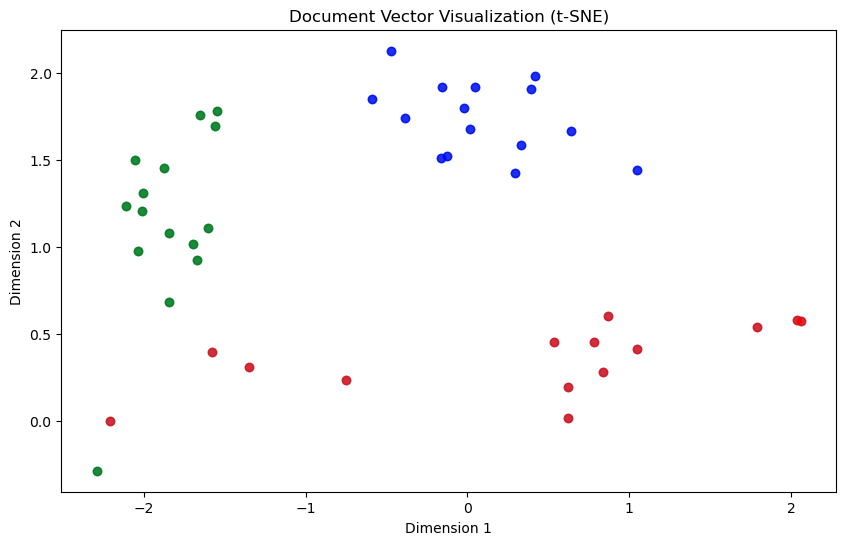

In [24]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import pickle
import os

# Load document_vectors from a file
with open("../02-data/03-VSM/glove-demo.pkl", "rb") as f:
    document_vectors = pickle.load(f)
 
if len(document_vectors) == 0:
    raise ValueError("No document vectors available for t-SNE visualization.")
    
# Extract document vectors
doc_paths = list(document_vectors.keys())  # File paths as labels
doc_vectors = np.array(list(document_vectors.values()))  # Convert dict to array

# Reduce to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=min(30, len(doc_vectors) - 1), random_state=42)
doc_vectors_2d = tsne.fit_transform(doc_vectors)

# Plot the reduced vectors
plt.figure(figsize=(10, 6))
plt.scatter(doc_vectors_2d[:, 0], doc_vectors_2d[:, 1], alpha=0.7)

for i, path in enumerate(doc_paths):
    color = get_category_color(path)  # Get color based on path
    plt.scatter(doc_vectors_2d[i, 0], doc_vectors_2d[i, 1], color=color, alpha=0.7)

    #if i % 5 == 0:  # Label every 5th document for readability
        #plt.annotate(os.path.basename(path), (doc_vectors_2d[i, 0], doc_vectors_2d[i, 1]))


plt.title("Document Vector Visualization (t-SNE)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


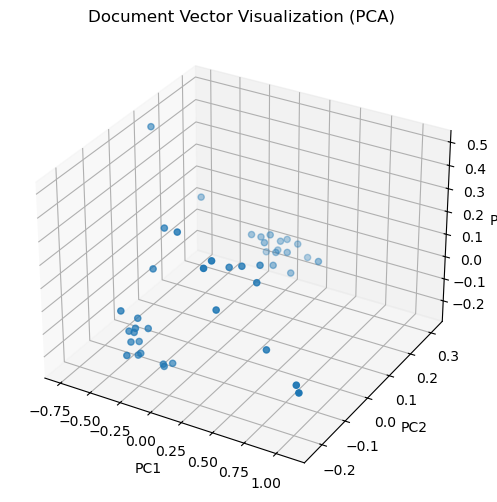

In [25]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D using PCA
pca = PCA(n_components=3)
doc_vectors_3d = pca.fit_transform(doc_vectors)

# Plot in 3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(doc_vectors_3d[:, 0], doc_vectors_3d[:, 1], doc_vectors_3d[:, 2])

ax.set_title("Document Vector Visualization (PCA)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()


-------------------------------------
Now we are getting into other metrics (nearest neighbors for example)


How to really do transfer learning using Google’s pre-trained model for your customized dataset?
It is often argued that there is little to no benefits to continue the training on Word2Vec model.

Imagine a situation that you have a small customized dataset so that the word2vec model you trained is not good enough but you also worried that pre-trained vectors do not really make sense for you for some common words. I argue that this is a pretty common situation and that is why transfer learning on Convolutional Neural networks are so popular.

https://phdstatsphys.wordpress.com/2018/12/27/word2vec-how-to-train-and-update-it/

-----------------
glove implementation

In [21]:
import os
import numpy as np
import pickle
import logging


# Load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def create_vector_representation(file_path, embeddings_index):
    
    if not os.path.exists(file_path):
        logging.warning(f"File not found: {file_path}, Skipping...")
        return None
    
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
        words = text.split()
        # Initialize an empty vector
        vector_representations = []
        for word in words:
            if word in embeddings_index:
                vector_representations.append(embeddings_index[word])
        
        # Aggregate vectors (e.g., average)
        if vector_representations:
            avg_vector = np.mean(vector_representations, axis=0)
            return avg_vector
        else:
            return None

def load_vectors_pickle(input_path):
    with open(input_path, 'rb') as f:
        return pickle.load(f)  # This will return a dictionary

def save_vectors_pickle(vectors_dict, output_path):
    with open(output_path, 'wb') as f:
        pickle.dump(vectors_dict, f)

# Example usage
directory ='../02-data/00-testing/03-demo/'
glove_file = '../02-data/03-VSM/glove.6B/glove.6B.100d.txt'  
embeddings_index = load_glove_embeddings(glove_file)

logging.info(f"Processing directory: {directory}")
corpus_vectors = {}

for root, _, _ in os.walk(directory):

    file_name = os.path.basename(root)
    txt_filename = os.path.join(root, f"{file_name}.txt")

    doc_vector = create_vector_representation(txt_filename, embeddings_index)
    
    if doc_vector is not None:
        corpus_vectors[root] = doc_vector  # ✅ Store correctly
        logging.info(f"Vector representation for {root}: ")
    else:
        logging.info(f"No valid GloVe vectors found for {txt_filename}")

output_npz = '../02-data/03-VSM/glove-demo.npz'
output_pickle = '../02-data/03-VSM/glove-demo.pkl'
save_vectors_pickle(corpus_vectors, output_pickle)

logging.info(f"Processed {len(corpus_vectors)} documents successfully.")